# Bayesian analysis of pulse train data

### Acoustic emission of gas bubbles in liquid

In [1]:
import bubblegram as bgram

In [2]:
from matplotlib import pyplot as plt

In [366]:
import numpy as np
from joblib import Parallel, delayed
from itertools import product

class pulse:
    
    def __init__(self, y, t):

        self.N = len(y)

        self.y = y
        self.t = t
        self.s_y2 = y.dot(y)

        self.t_min = t[3]
        self.t_max = t[-3]

    def __w(self, delta, t0):
        v = np.exp(-delta*(self.t-t0))
        v[np.where(self.t < t0)] = 0
        return v
        
    def __phi(self, omega):
        return np.cos(2*np.pi*omega*self.t)
    
    def __psi(self, omega):
        return np.sin(2*np.pi*omega*self.t)
        
    def llhood(self, omega, delta, t0):

        w = self.__w(delta, t0)
        phi = self.__phi(omega)
        psi = self.__psi(omega)
        
        d = w*phi
        e = w*psi
        
        sum_d2 = d.dot(d)
        sum_e2 = e.dot(e)
        sum_yd = self.y.dot(d)
        sum_ye = self.y.dot(e)
        
        
        Z0 = np.log(d.dot(d)) + np.log(e.dot(e))
        
        Z = self.s_y2 - ((sum_yd**2)/sum_d2 + (sum_ye**2)/sum_e2)
        if Z > 0:
            ll = 0.5*Z0 - ((self.N+1)/2)*np.log(Z)
            #ll =  - ((self.N+1)/2)*np.log(Z)
        else:
            print("Z = {}".format(Z))
            ll = -np.infty

        return ll
    
    def get_llhood_t(self, omega, delta, npoints = 100):
        
        _t = np.linspace(self.t_min, self.t_max, npoints)
        
        L = np.zeros(npoints)
        
        from joblib import Parallel, delayed        
        
        #lL = Parallel(n_jobs = -1)(delayed(self.llhood)(omega, delta, t) for t in _t)
        #L = np.array(lL)
        for i in range(npoints):
            L[i] = self.llhood(omega, delta, _t[i])
            
        return _t, L

    def _M(self, omega, l, n_grid_t):
        _, p = self.get_llhood_t(omega, l, n_grid_t)

        mp = np.max(p)
        Z = (np.sum(np.exp(p - mp))) + mp

        return Z

    

def pulsogram(obj, omega_min, omega_max, n_omega, delta_min, delta_max, n_delta, n_grid_t = 100):

    linomega = np.linspace(omega_min, omega_max, n_omega)
    lindelta = np.linspace(delta_min, delta_max, n_delta)

    from joblib import Parallel, delayed
    from itertools import product

    lM = Parallel(n_jobs=-1)(delayed(obj._M)(ol[0],ol[1], n_grid_t) for ol in product(linomega, lindelta))
    M = np.array(lM)
    M = np.reshape(M, [n_omega, n_delta])    

    return M, linomega, lindelta


class abubble:
    
    def __init__(self, y, t):

        # Parameters based on water at 20 degrees Celsius
        self.N = len(y)

        self.y = y
        self.t = t
        self.s_y2 = y.dot(y)

        self.t_min = t[3]
        self.t_max = t[-15]
        
        # Specific heat
        self.__gamma = 1.4
        
        # Density
        self.__rho = 998
        
        # Atmospheric pressure
        self.__p = 101325        
        
        # Vapour pressure
        self.__pv = 2.3

        # Surface tension
        self.__tau = 72.87

        # Shear viscosity
        self.__eta = 1.0016       
        
        # Thermodynamic constant
        self.__kappa = self.__gamma      
        
        # Number of harmonics
        self.__nharm = 1

    def __w(self, delta, t0):
        v = np.exp(-delta*(self.t-t0))
        v[np.where(self.t < t0)] = 0
        return v
    
    def w(self, delta, t0):
        return self.__w(delta, t0)
        
    def __phi(self, omega):
        phi = np.zeros(self.N)
        for i in range(self.__nharm):
            phi = phi + np.cos(2*np.pi*(i+1)*omega*self.t)
        return phi
    
    def phi(self, omega):
        return self.__phi(omega)
    
    def __psi(self, omega):
        psi = np.zeros(self.N)
        for i in range(self.__nharm):
            psi = psi + np.sin(2*np.pi*(i+1)*omega*self.t)
        return psi
    
    def psi(self, omega):
        return self.__psi(omega)
        
    def __omega(self, r):
        return (1/(r*np.sqrt(self.__rho)))*np.sqrt(3*self.__kappa*(self.__rho-self.__pv + 2*self.__tau/r) - 2*self.__tau/r + self.__pv - 4*self.__eta*self.__eta/(self.__rho*r*r))
    
    def omega(self, r):
        return self.__omega(r)    
    
    def __delta(self, r):
        f0 = self.__omega(r)
        return np.pi * (0.014 + (1.1 * 10**(-5))*f0) * f0
    
    def delta(self, r):
        return self.__delta(r)

    
    def llhood(self, r, t0):

        # Frequency
        omega = self.__omega(r)
        
        # Dumping
        delta = self.__delta(r)
        
        w = self.__w(delta, t0)
        phi = self.__phi(omega)
        psi = self.__psi(omega)
        
        d = w*phi
        e = w*psi
        
        sum_d2 = d.dot(d)
        sum_e2 = e.dot(e)
        sum_yd = self.y.dot(d)
        sum_ye = self.y.dot(e)
        
        
        Z0 = np.log(d.dot(d)) + np.log(e.dot(e))
        
        Z = self.s_y2 - ((sum_yd**2)/sum_d2 + (sum_ye**2)/sum_e2)
        if Z > 0:
            ll = -0.5 * Z0 - ((self.N+1)/2)*np.log(Z)
            #ll =  - ((self.N+1)/2)*np.log(Z)
        else:
            print("Z = {}".format(Z))
            ll = -np.infty

        return ll
    
    def get_llhood_t(self, r, npoints = 100):
        
        _t = np.linspace(self.t_min, self.t_max, npoints)
        
        L = np.zeros(npoints)
        for i in range(npoints):
            L[i] = self.llhood(r, _t[i])
            
        return _t, L

    def _M(self, r, n_grid_t):
        _, p = self.get_llhood_t(r, n_grid_t)

        return p

    

def bubblegram(obj, r_min, r_max, n_r, n_grid_t = 100):

    linr = np.linspace(r_min, r_max, n_r)

    from joblib import Parallel, delayed
    from itertools import product

    lM = Parallel(n_jobs=-1)(delayed(obj._M)(ol, n_grid_t) for ol in linr)
    M = np.array(lM)
    M = np.reshape(M, [n_r, n_grid_t])    

    return M, linr

## Bayesian analysis of simulated pulse

Frequency and dumping factor independent

Comparing likelihood for different values of $\omega$ and $\delta$

In [12]:
%%time
o = pulse(y, t)
param1 = (omega, l)
param2 = (omega, 1)
param3 = (omega, 26)
t1, p1 = o.get_llhood_t(param1[0], param1[1], npoints = 100)
t2, p2 = o.get_llhood_t(param2[0], param2[1], npoints = 100)
t3, p3 = o.get_llhood_t(param3[0], param3[1], npoints = 100)

CPU times: user 76.1 ms, sys: 3.7 ms, total: 79.8 ms
Wall time: 79 ms


In [8]:
%%time
o = bgram.pulse(y, t)
param1 = (omega, l)
param2 = (omega, 1)
param3 = (omega, 26)
p1 = o.get_llhood_t(param1[0], param1[1], npoints = 100)
p2 = o.get_llhood_t(param2[0], param2[1], npoints = 100)
p3 = o.get_llhood_t(param3[0], param3[1], npoints = 100)

CPU times: user 293 ms, sys: 171 µs, total: 293 ms
Wall time: 293 ms


$ \sum e^{l_i} = e^{C} \sum e^{l_i}e^{-C} = e^{C} \sum e^{l_i-C}$

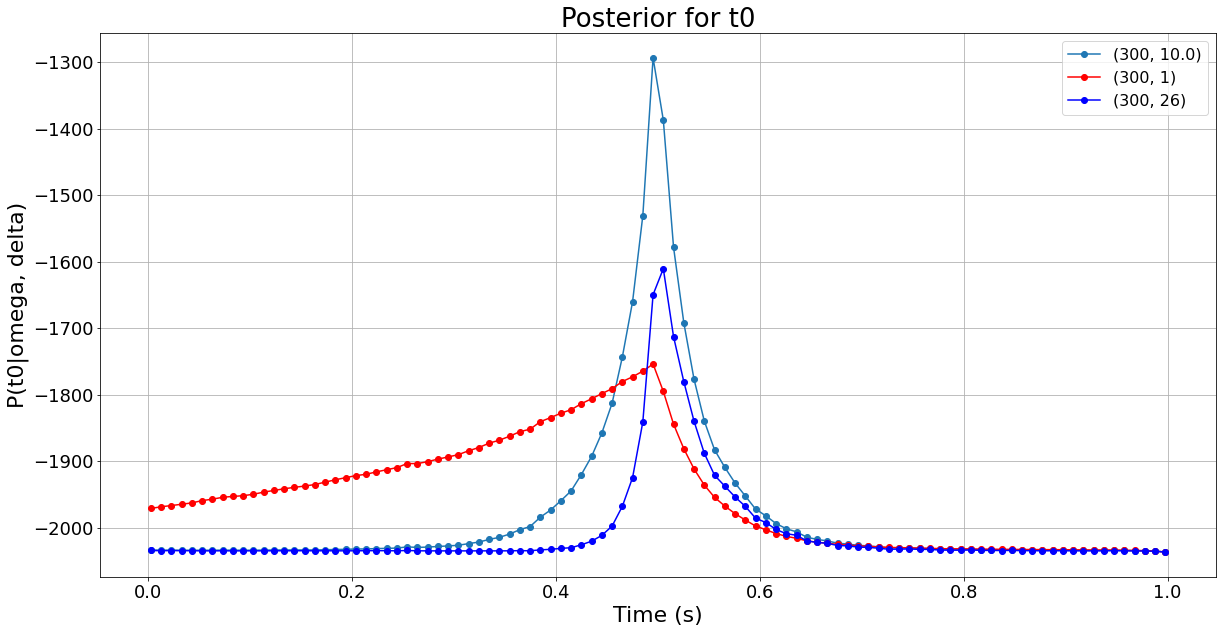

In [9]:
fig = plt.figure(figsize = (20, 10))

#plt.plot(t1, np.exp(p1/np.max(np.abs(p1))), '-o', label = param1)
#plt.plot(t2, np.exp(p2/np.max(np.abs(p2))), '-o', color = 'red', label = param2)
#plt.plot(t3, np.exp(p3/np.max(np.abs(p3))), '-o', color = 'blue', label = param3)

plt.plot(t1, p1, '-o', label = param1)
plt.plot(t2, p2, '-o', color = 'red', label = param2)
plt.plot(t3, p3, '-o', color = 'blue', label = param3)

plt.xlabel('Time (s)', fontsize = 22)
plt.ylabel('P(t0|omega, delta)', fontsize = 22)
plt.title('Posterior for t0', fontsize = 26)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.legend(fontsize = 16)
plt.grid(True)
plt.show()

Pulsogram

In [13]:
n_omega = 100
n_delta = 100
omega_min = 100
omega_max = 500
delta_min = 1
delta_max = 80

In [14]:
o = pulse(y, t)

In [15]:
%%time
M, linomega, lindelta = pulsogram(o, omega_min, omega_max, n_omega, delta_min, delta_max, n_delta)

CPU times: user 17.3 s, sys: 238 ms, total: 17.5 s
Wall time: 34.9 s


In [46]:
o = bgram.pulse(y, t)

In [ ]:
%%time
M, linomega, lindelta = o.pulsogram(omega_min, omega_max, n_omega, delta_min, delta_max, n_delta, 100)

Maximum evidence with uninformative priors: 

$argmax_{(\omega,\delta)} \int P(\omega, \delta, t_0 | y) dt_0$

In [16]:
i, j = np.unravel_index(np.argmax(M, axis=None), M.shape)
omega_opt, l_opt = (linomega[i], lindelta[j])

topt, p = o.get_llhood_t(omega_opt, l_opt)
t_opt = topt[np.argmax(p)]

print("Maximum evidence for frequency {:.5} Hz (true = {} Hz) and dumping constant {:.5} starting at {:.4} s (true {:.5} at {:.4})".format(omega_opt, omega, l_opt, t_opt, l, t0))

Maximum evidence for frequency 297.98 Hz (true = 300 Hz) and dumping constant 12.97 starting at 0.4955 s (true 10.0 at 0.5)


Plotting fitted model with unknown amplitudes

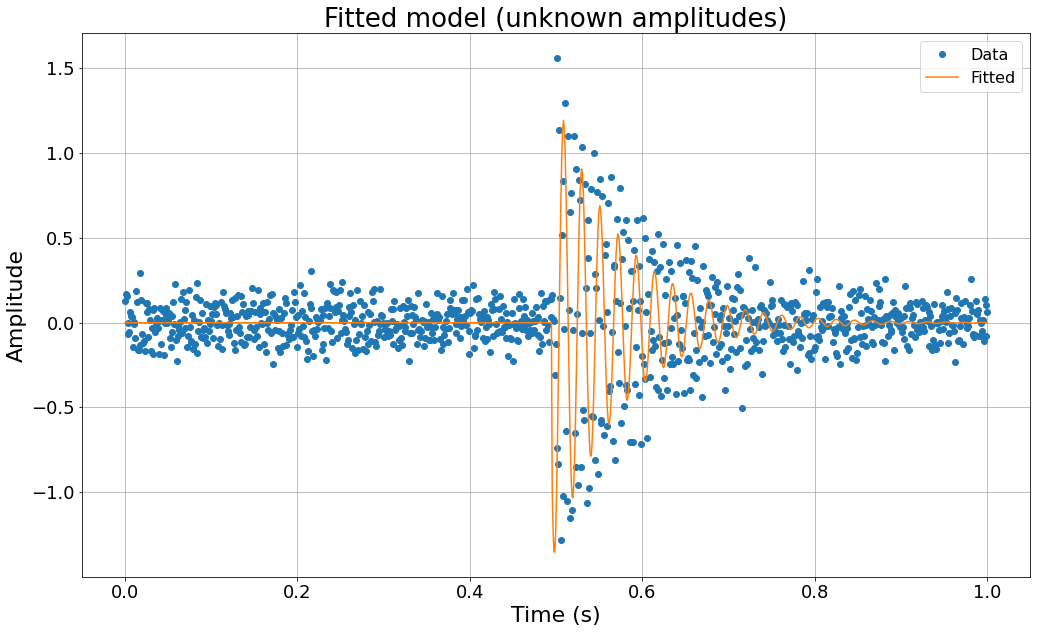

In [17]:
y_fit = np.exp(-l_opt*(t-t_opt))*(np.cos(omega_opt*t) + np.sin(omega_opt*t))
y_fit[np.where(t < t_opt)] = 0

fig = plt.figure(figsize = (17, 10))
plt.plot(t, y, 'o', label = 'Data')
plt.plot(t, y_fit, '-', label = 'Fitted')
plt.xlabel('Time (s)', fontsize = 22)
plt.ylabel('Amplitude', fontsize = 22)
plt.title('Fitted model (unknown amplitudes)', fontsize = 26)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.legend(fontsize = 16)
plt.grid(True)
plt.show()

Plotting pulsogram

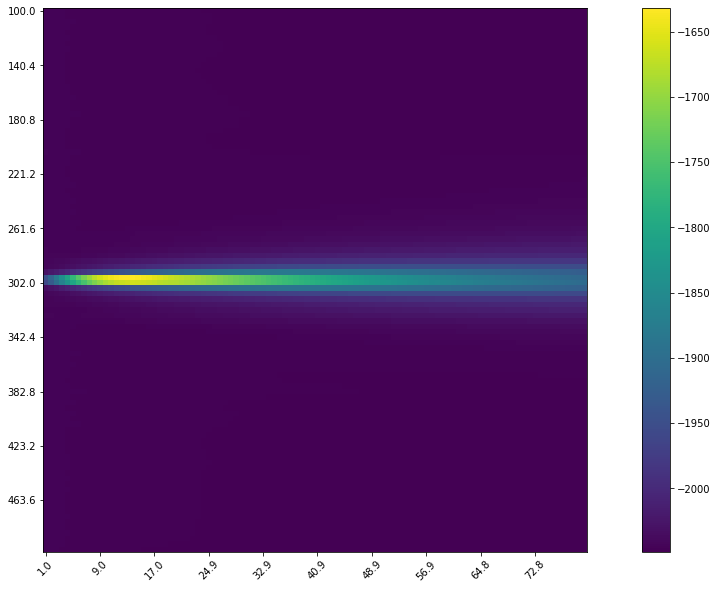

In [18]:
fig = plt.figure(figsize = (20, 10))
plt.imshow(M)

ticks_x = np.arange(0, len(lindelta), step = int(len(lindelta)/10))
plt.xticks(ticks_x, ["{:3.1f}".format(d) for d in lindelta[ticks_x]], rotation = 45)

ticks_y = np.arange(0, len(linomega), step = int(len(linomega)/10))
plt.yticks(ticks_y, ["{:4.1f}".format(o) for o in linomega[ticks_y]])

plt.colorbar()

plt.show()

# Simulated data - frequency and dumping constant linearly related

In [399]:
# Specific heat
gamma = 1.4

# Thermodynamic constant
kappa = gamma

# Density
rho = 998

# Atmospheric pressure
p = 101325  

# Vapour pressure
pv = 2.3

# Surface tension
tau = 72.87

# Shear viscosity
eta = 1.0016

In [409]:
# Radius and starting time
r = 10 / 1000
t0 = 0.5

# Calculating frequency and dumping constant
omega = (1/(r*np.sqrt(rho)))*np.sqrt(3*kappa*(rho-pv + 2*tau/r) - 2*tau/r + pv - 4*eta*eta/(rho*r*r))
l = np.pi * (0.014 + (1.1 * 10**(-5))*omega) * omega

# Amplitudes
A = 1
B = 1

In [419]:
from scipy.optimize import newton_krylov

def f(r):
    return (1/(r*np.sqrt(rho)))*np.sqrt(3*kappa*(rho-pv + 2*tau/r) - 2*tau/r + pv - 4*eta*eta/(rho*r*r))-omega*.5

    
newton_krylov(f, xin = r/3)*1000

16.138811899781263

In [431]:
noise = np.random.normal(loc = 0, scale = 0.1, size = 10000)
t = np.linspace(0, 1, 10000)

f = np.exp(-l*(t-t0))*(A*np.cos(2*np.pi*omega*t) + B*np.sin(2*np.pi*omega*t))
n0 = np.min(np.where(t >= t0))
f[:n0] = 0

y = noise + f

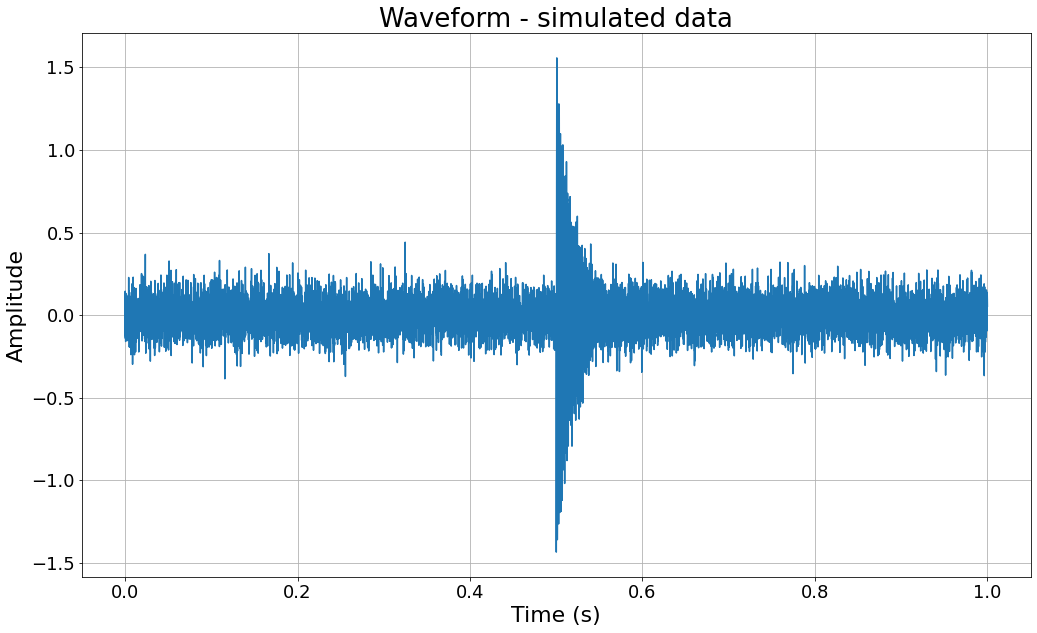

In [432]:
fig = plt.figure(figsize = (17, 10))
plt.plot(t, y)
plt.xlabel('Time (s)', fontsize = 22)
plt.ylabel('Amplitude', fontsize = 22)
plt.title('Waveform - simulated data', fontsize = 26)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.grid(True)
plt.show()

In [433]:
r_min = 5. / 1000
r_max = 20. / 1000
n_r = 500
n_t = 500

In [434]:
%%time
o = abubble(y, t)
M, linr = bubblegram(o, r_min, r_max, n_r, n_t)
lint = np.linspace(o.t_min, o.t_max, n_t)

CPU times: user 6.57 s, sys: 241 ms, total: 6.81 s
Wall time: 59.7 s


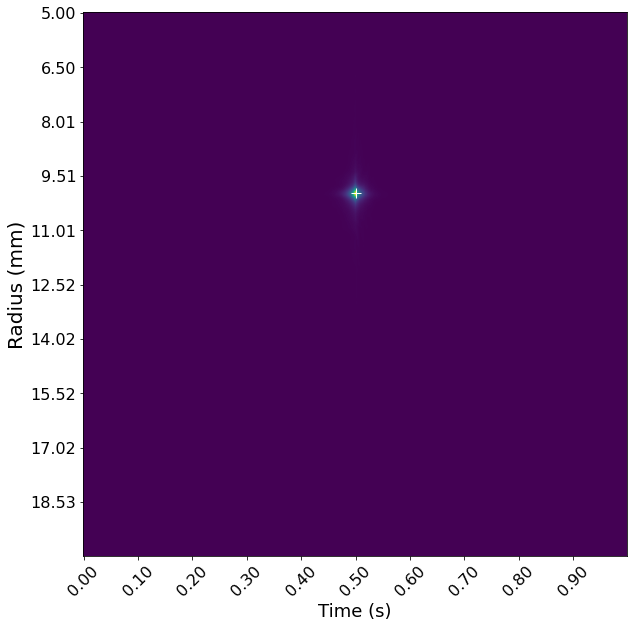

In [435]:
fig = plt.figure(figsize = (20, 10))
plt.imshow(M)

ticks_x = np.arange(0, len(lint), step = int(len(lint)/10))
plt.xticks(ticks_x, ["{:1.2f}".format(d) for d in lint[ticks_x]], rotation = 45, fontsize = 16)
plt.xlabel("Time (s)", fontsize = 18)

ticks_y = np.arange(0, len(linr), step = int(len(linr)/10))
plt.yticks(ticks_y, ["{:1.2f}".format(1000*o) for o in linr[ticks_y]], fontsize = 16)
plt.ylabel("Radius (mm)", fontsize = 20)

plt.plot(np.argmin(abs(lint-t0)), np.argmin(abs(linr - r)), 'w+', markersize = 10)

plt.show()

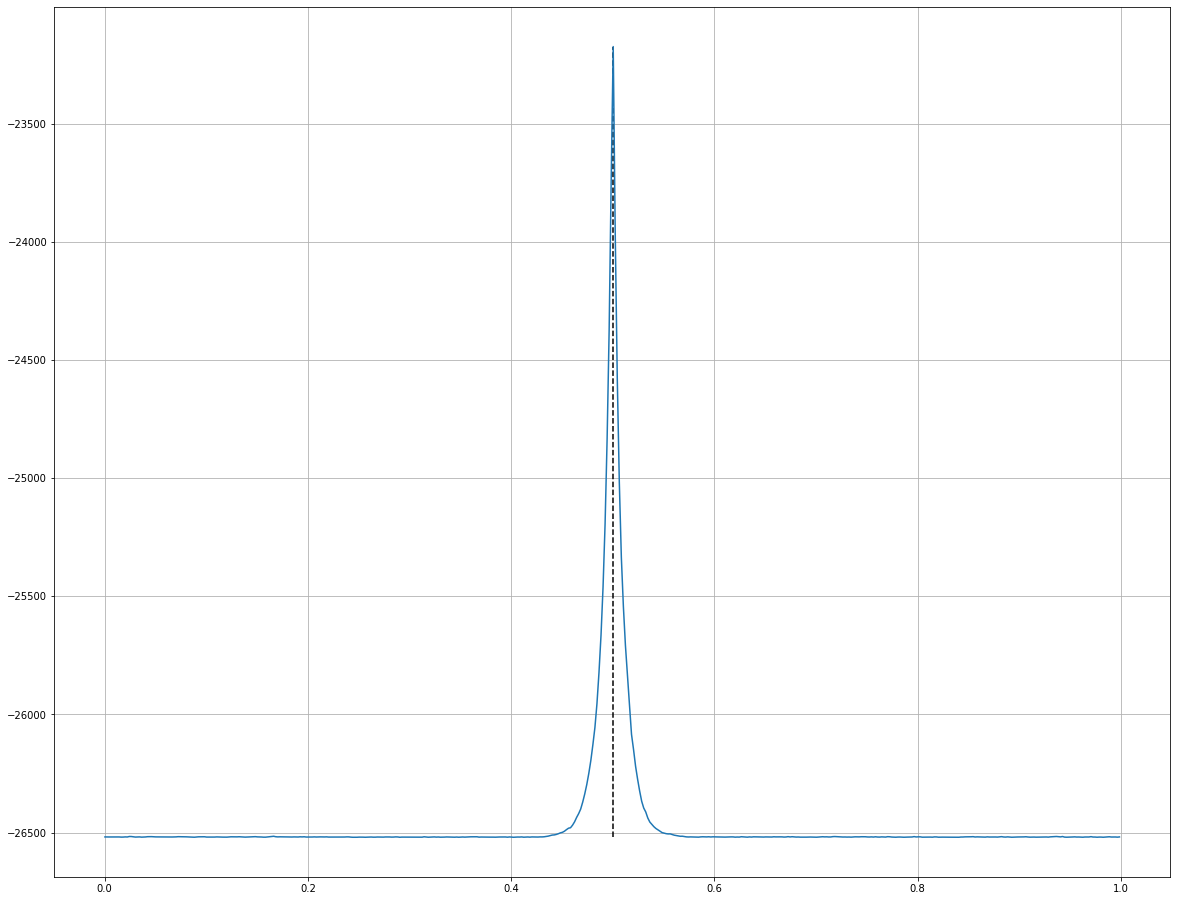

In [436]:
maxlike = np.max(M, axis = 0)
fig = plt.figure(figsize = (20, 16))
plt.plot(lint, maxlike)

plt.vlines(x = t0, ymin = min(maxlike), ymax = max(maxlike), linestyles = '--')

plt.grid(True)
plt.show()

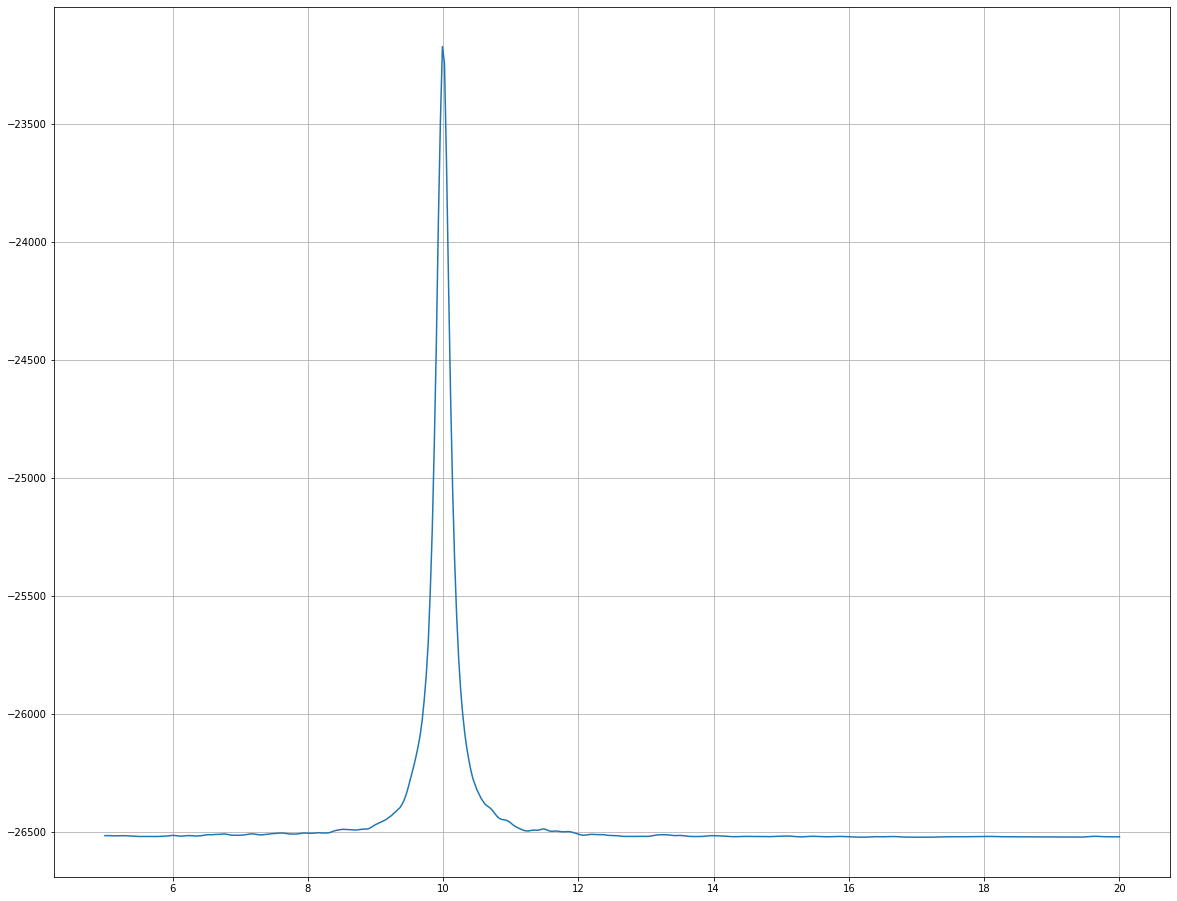

In [437]:
fig = plt.figure(figsize = (20, 16))
plt.plot(linr*1000, M[:,250])

#plt.vlines(x = t0, ymin = min(maxlike), ymax = max(maxlike), linestyles = '--')

plt.grid(True)
plt.show()

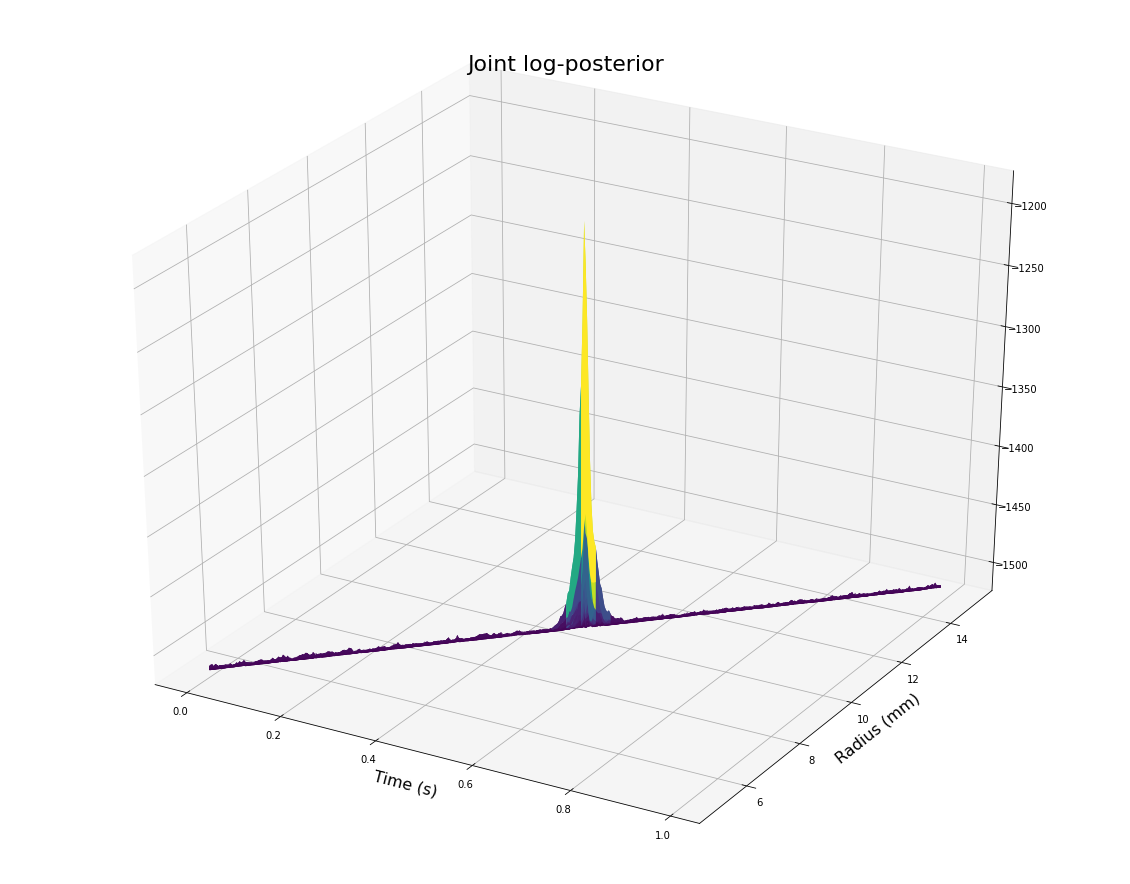

In [406]:
from mpl_toolkits import mplot3d

fig = plt.figure(figsize = (20, 16))
ax = plt.axes(projection='3d')

ax.plot_surface(lint, 1000*linr, M,cmap='viridis', edgecolor='none')
ax.set_title('Joint log-posterior', fontsize = 22)
plt.xlabel("Time (s)", fontsize = 16)
plt.ylabel("Radius (mm)", fontsize = 16)
plt.show()


# Simulated data - sequence of bubbles

In [478]:
N = 10000
tmax = 1
t = np.linspace(0, tmax, N)
y = np.zeros(N)

nbubbles = 10
tstart = np.random.uniform(0, tmax, nbubbles)
rs = np.random.uniform(5, 15, nbubbles) / 1000
for i in range(nbubbles):
    
    # Radius and starting time    
    t0 = tstart[i]
    r = rs[i]

    # Calculating frequency and dumping constant
    omega = (1/(r*np.sqrt(rho)))*np.sqrt(3*kappa*(rho-pv + 2*tau/r) - 2*tau/r + pv - 4*eta*eta/(rho*r*r))
    l = np.pi * (0.014 + (1.1 * 10**(-5))*omega) * omega

    # Amplitudes
    A = 1
    B = 1

    noise = np.random.normal(loc = 0, scale = 0.05, size = N)

    f = np.exp(-l*(t-t0))*(A*np.cos(2*np.pi*omega*t) + B*np.sin(2*np.pi*omega*t))
    n0 = np.min(np.where(t >= t0))
    f[:n0] = 0

    y = y + noise + f

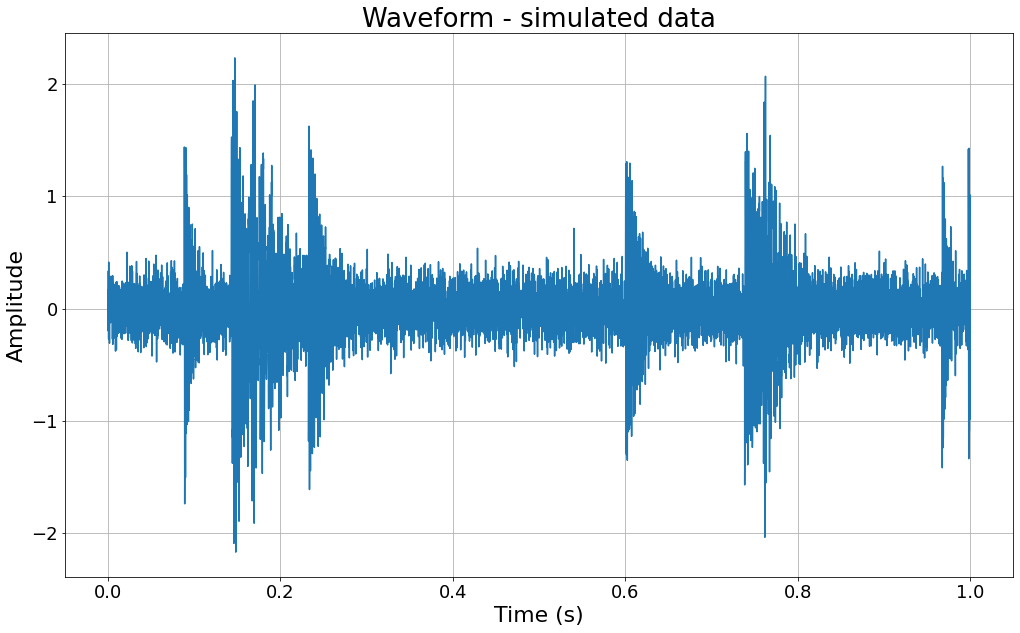

In [479]:
fig = plt.figure(figsize = (17, 10))
plt.plot(t, y)
plt.xlabel('Time (s)', fontsize = 22)
plt.ylabel('Amplitude', fontsize = 22)
plt.title('Waveform - simulated data', fontsize = 26)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.grid(True)
plt.show()

In [480]:
r_min = 2. / 1000
r_max = 20. / 1000
n_r = 500
n_t = 500

In [481]:
%%time
o = abubble(y, t)
M, linr = bubblegram(o, r_min, r_max, n_r, n_t)
lint = np.linspace(o.t_min, o.t_max, n_t)

CPU times: user 6.54 s, sys: 105 ms, total: 6.64 s
Wall time: 1min


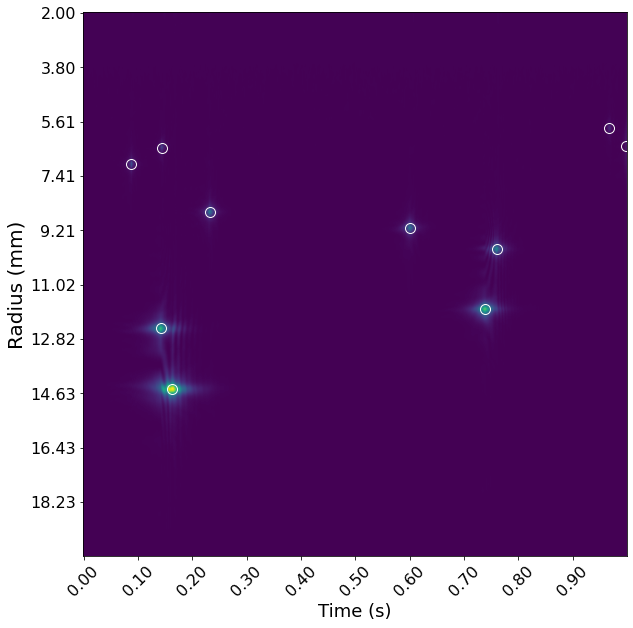

In [483]:
fig = plt.figure(figsize = (20, 10))
plt.imshow(M)

ticks_x = np.arange(0, len(lint), step = int(len(lint)/10))
plt.xticks(ticks_x, ["{:1.2f}".format(d) for d in lint[ticks_x]], rotation = 45, fontsize = 16)
plt.xlabel("Time (s)", fontsize = 18)

ticks_y = np.arange(0, len(linr), step = int(len(linr)/10))
plt.yticks(ticks_y, ["{:1.2f}".format(1000*o) for o in linr[ticks_y]], fontsize = 16)
plt.ylabel("Radius (mm)", fontsize = 20)

for i in range(nbubbles):
    plt.plot(np.argmin(abs(lint-tstart[i])), np.argmin(abs(linr - rs[i])), 'wo', markerfacecolor = "None", markersize = 10)

plt.show()

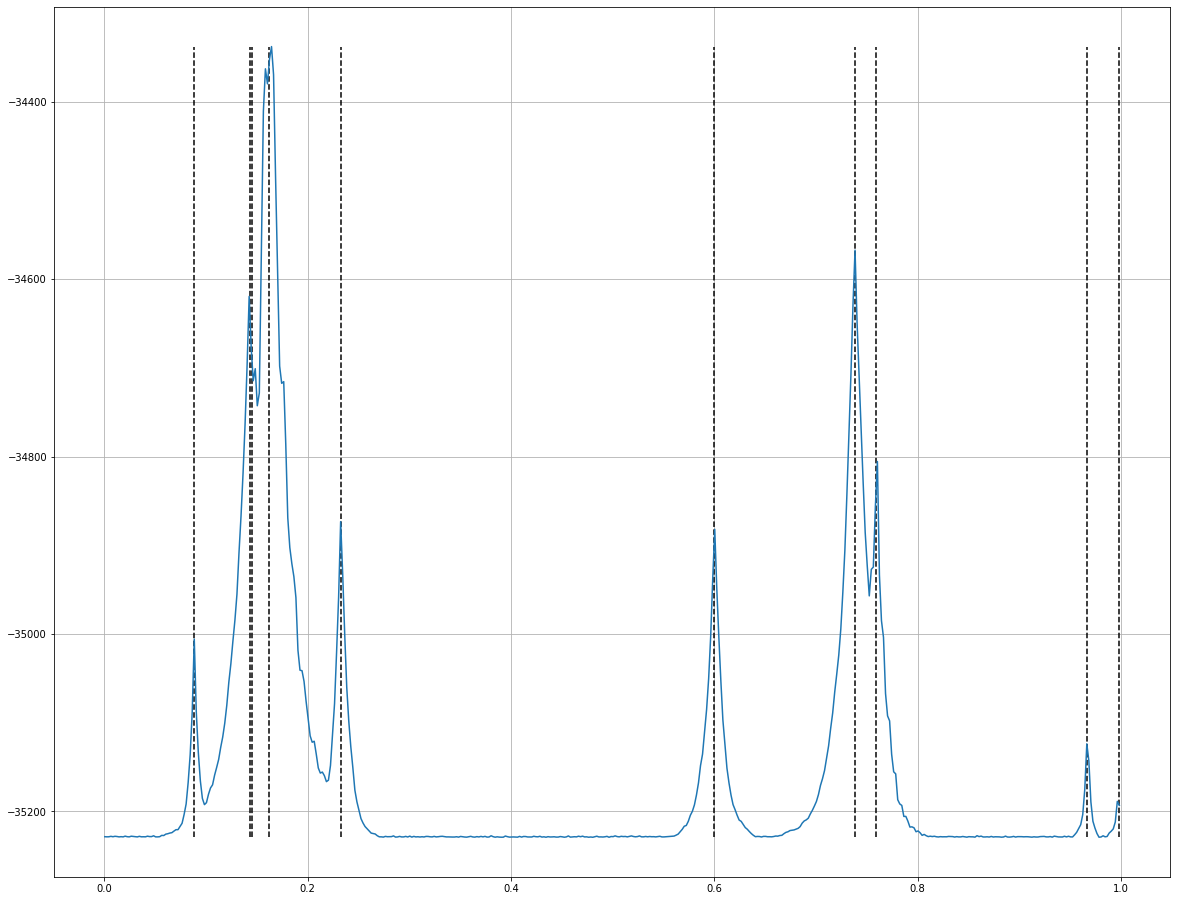

In [484]:
maxlike = np.max(M, axis = 0)
fig = plt.figure(figsize = (20, 16))
plt.plot(lint, maxlike)

for i in range(nbubbles):
    plt.vlines(x = tstart[i], ymin = min(maxlike), ymax = max(maxlike), linestyles = '--')

plt.grid(True)
plt.show()

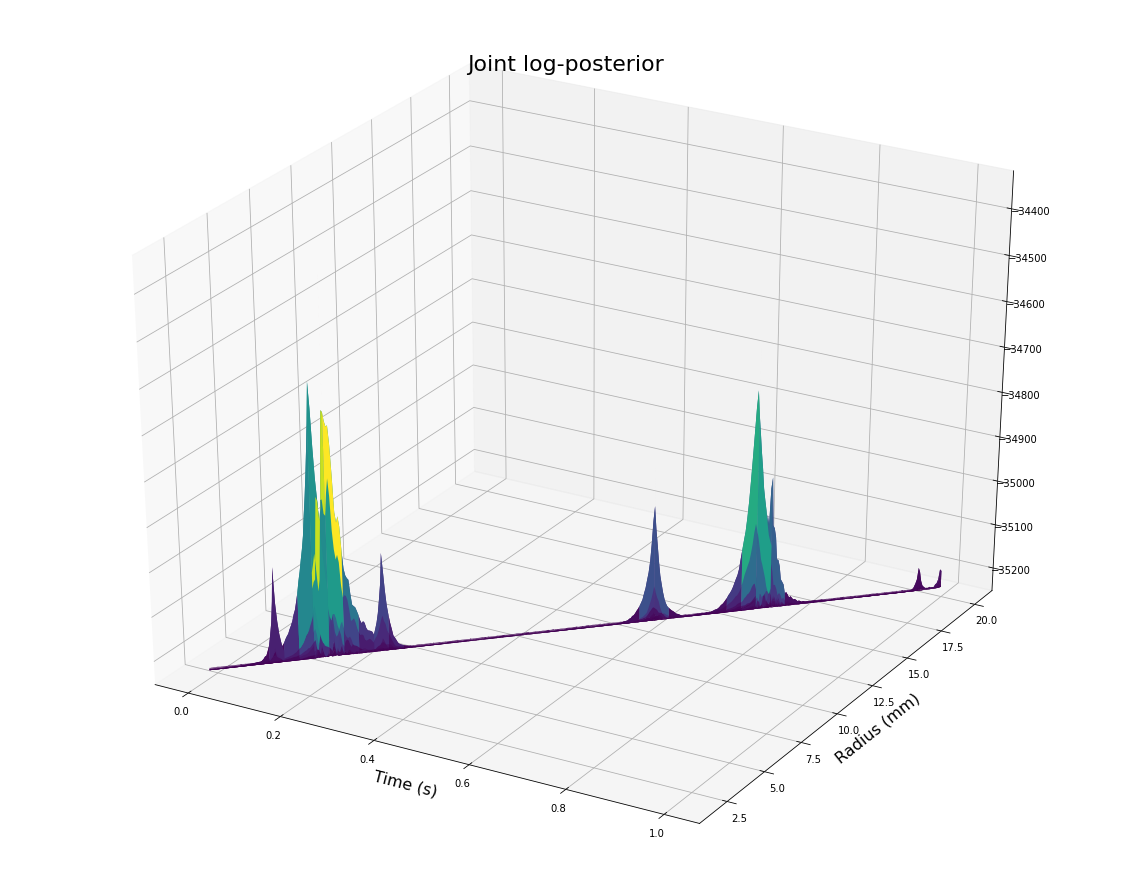

In [485]:
from mpl_toolkits import mplot3d

fig = plt.figure(figsize = (20, 16))
ax = plt.axes(projection='3d')

ax.plot_surface(lint, 1000*linr, M,cmap='viridis', edgecolor='none')
ax.set_title('Joint log-posterior', fontsize = 22)
plt.xlabel("Time (s)", fontsize = 16)
plt.ylabel("Radius (mm)", fontsize = 16)
plt.show()

# Testing on lab data

In [486]:
import scipy.io.wavfile

wav = 'data/Q0#1.wav'

fs, y = scipy.io.wavfile.read(wav)
y = y / max(y)
t = np.linspace(0, len(y)/fs, len(y))

print("{} seconds of signal, {} points".format(len(y)/fs, len(y)))

29.994666666666667 seconds of signal, 2879488 points


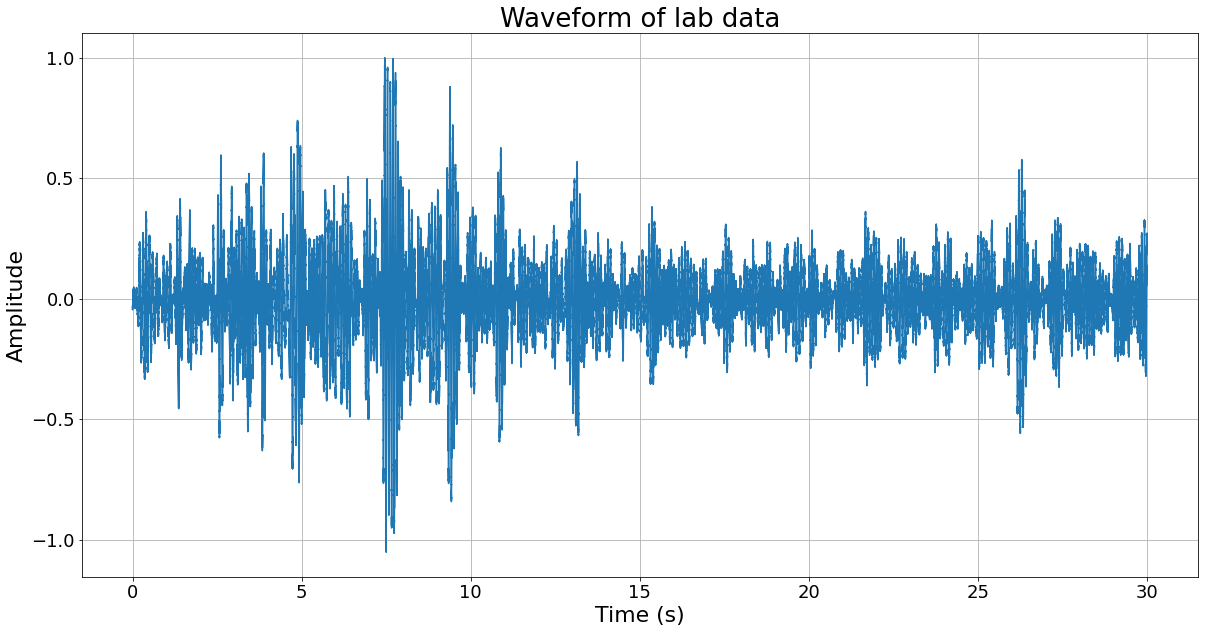

In [487]:
fig = plt.figure(figsize = (20, 10))
plt.plot(t, y)
plt.xlabel('Time (s)', fontsize = 22)
plt.ylabel('Amplitude', fontsize = 22)
plt.title('Waveform of lab data', fontsize = 26)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.grid(True)
plt.show()

### Bandpass filter

In [488]:
low_pass = 200
high_pass = 2000

In [489]:
from scipy.signal import butter, sosfilt, decimate

N = 20
sos = butter(N, [low_pass,high_pass], 'bandpass', fs = fs, output='sos')
yf = sosfilt(sos, y)

Selecting section and playing

In [490]:
start_time = 7.5
end_time = 7.75

In [491]:
import sounddevice as sd
lb = int(start_time*fs)
ub = int(end_time*fs)

#sd.play(y[lb:ub], samplerate=fs)
yb = yf[lb:ub]
tb = t[lb:ub]
print("{} seconds, {} points".format(end_time - start_time, len(yb)))

0.25 seconds, 24000 points


Plot section. 

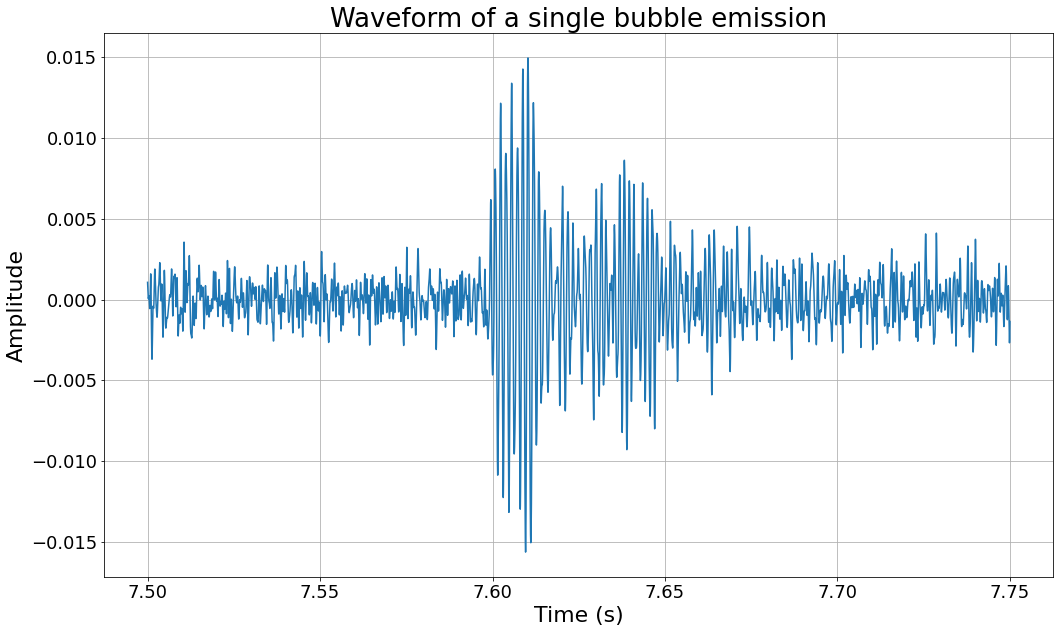

In [492]:
fig = plt.figure(figsize = (17, 10))
plt.plot(tb, yb)
plt.xlabel('Time (s)', fontsize = 22)
plt.ylabel('Amplitude', fontsize = 22)
plt.title('Waveform of a single bubble emission', fontsize = 26)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.grid(True)
plt.show()

### Decimating

In [493]:
yb = decimate(yb, 10)
fs = int(fs / 10)
tb = np.linspace(0, len(yb)/fs, len(yb))

print("{} seconds of signal, {} points".format(len(yb)/fs, len(yb)))

0.25 seconds of signal, 2400 points


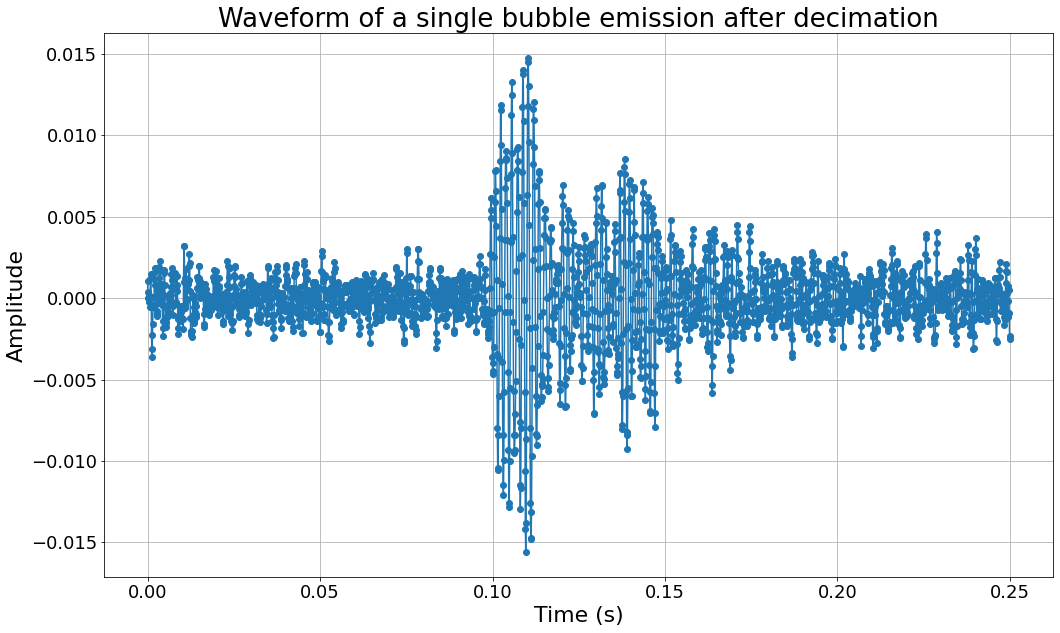

In [494]:
fig = plt.figure(figsize = (17, 10))
plt.plot(tb, yb, 'o-')
plt.xlabel('Time (s)', fontsize = 22)
plt.ylabel('Amplitude', fontsize = 22)
plt.title('Waveform of a single bubble emission after decimation', fontsize = 26)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.grid(True)
plt.show()

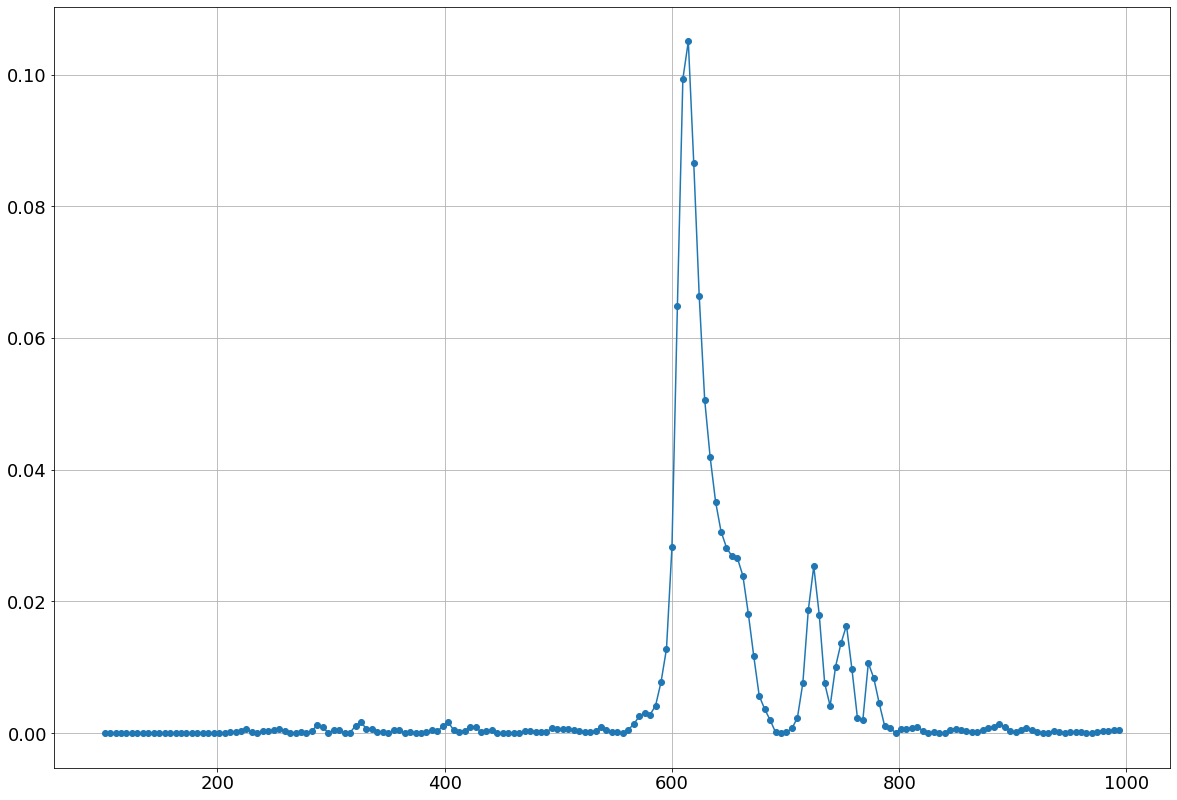

In [495]:
from scipy.signal import welch

f, psd = welch(yb, fs = fs, nperseg = 2000)


imin = np.argmin((f - 100)**2)
#imin = 0
imax = np.argmin((f - 1000)**2)
#imax = len(f)

psd = psd[imin:imax]    
f = f[imin:imax]
psd = psd / sum(psd)

plt.figure(figsize = (20, 14))
plt.plot(f, psd, 'o-')
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.grid(True)

# Modelling lab data

In [512]:
o = pulse(yb,tb)

In [513]:
param1 = (650, 43)
param2 = (1000, 43)
param3 = (650, 40)
t1, p = o.get_llhood_t(param1[0], param1[1])
t2, p2 = o.get_llhood_t(param2[0], param2[1])
t3, p3 = o.get_llhood_t(param3[0], param3[1])

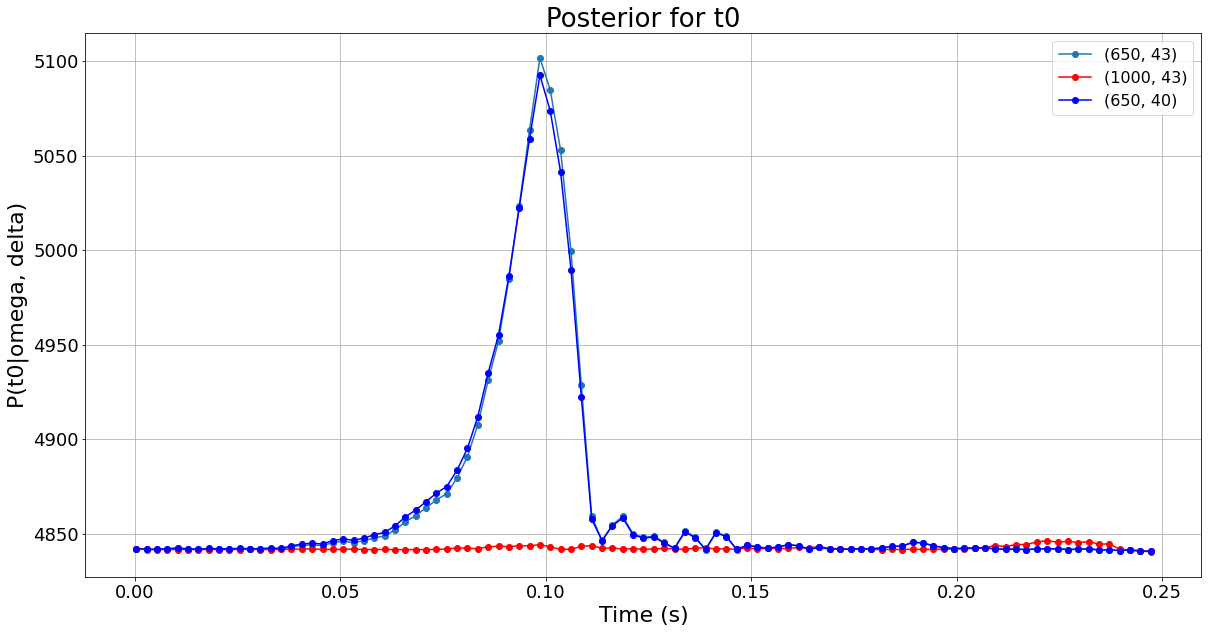

In [514]:
fig = plt.figure(figsize = (20, 10))

plt.plot(t1[:-1], p[:-1], '-o', label = param1)
plt.plot(t2[:-1], p2[:-1], '-o', color = 'red', label = param2)
plt.plot(t3[:-1], p3[:-1], '-o', color = 'blue', label = param3)

plt.xlabel('Time (s)', fontsize = 22)
plt.ylabel('P(t0|omega, delta)', fontsize = 22)
plt.title('Posterior for t0', fontsize = 26)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.legend(fontsize = 16)
plt.grid(True)
plt.show()

Pulsogram

In [515]:
omega_min = 100
omega_max = 1200
n_omega = 100
delta_min = 5
delta_max = 100
n_delta = 100

In [516]:
%%time
M, linomega, lindelta = pulsogram(o, omega_min, omega_max, n_omega, delta_min, delta_max, n_delta)

CPU times: user 25.7 s, sys: 424 ms, total: 26.1 s
Wall time: 1min 6s


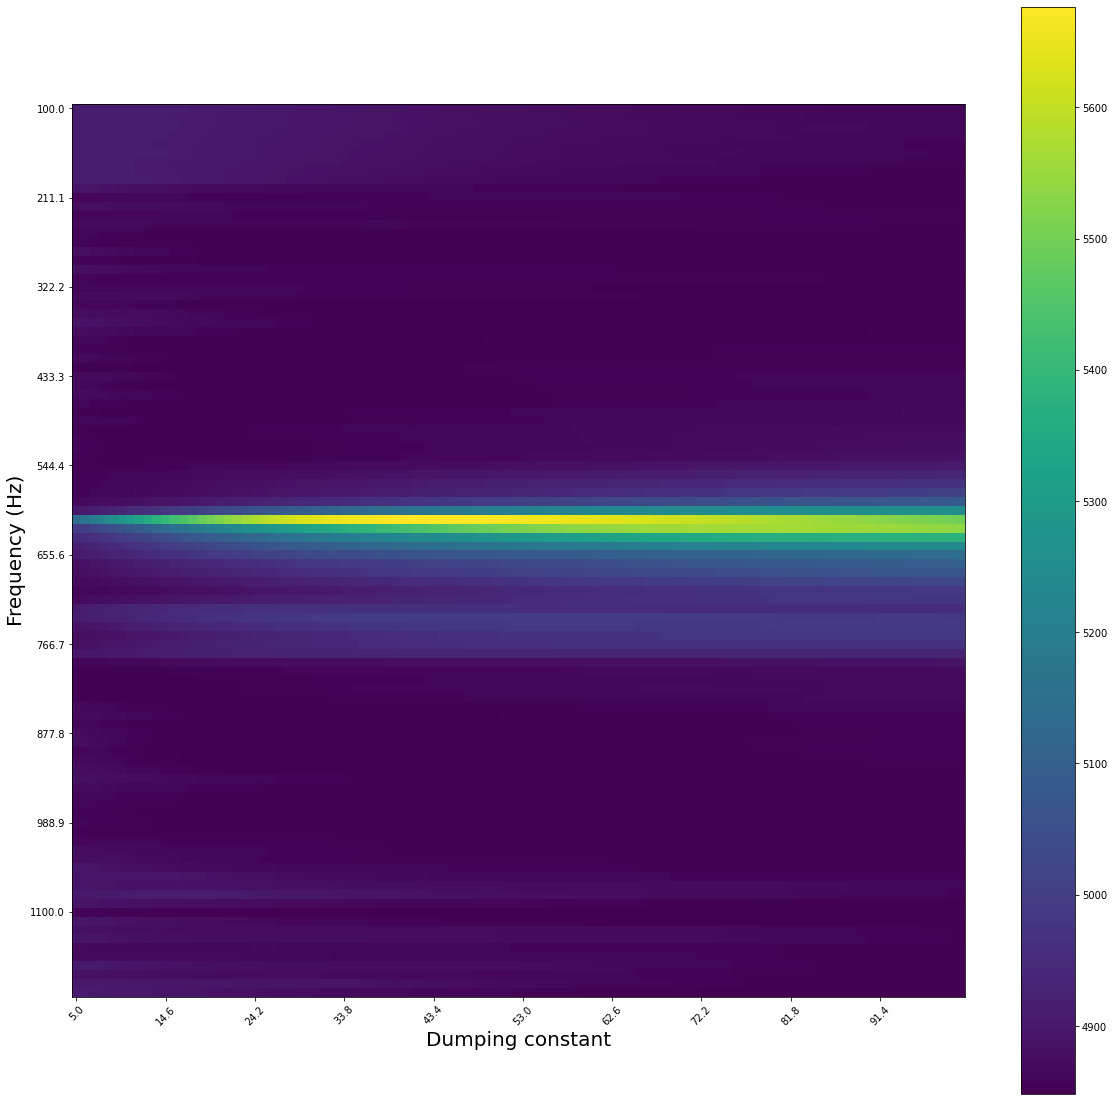

In [517]:
fig = plt.figure(figsize = (20, 20))
plt.imshow(M)

ticks_x = np.arange(0, len(lindelta), step = int(len(lindelta)/10))
plt.xticks(ticks_x, ["{:3.1f}".format(d) for d in lindelta[ticks_x]], rotation = 45)
plt.xlabel("Dumping constant", fontsize = 20)

ticks_y = np.arange(0, len(linomega), step = int(len(linomega)/10))
plt.yticks(ticks_y, ["{:4.1f}".format(o) for o in linomega[ticks_y]])
plt.ylabel("Frequency (Hz)", fontsize = 20)


plt.colorbar()
plt.show()

In [518]:
i, j = np.unravel_index(np.argmax(M, axis=None), M.shape)
omega_opt, l_opt = (linomega[i], lindelta[j])

topt, p = o.get_llhood_t(omega_opt, l_opt)
t_opt = topt[np.argmax(p)]

print("Maximum evidence for frequency {:.5} Hz and dumping constant {:.5} starting at {:.4} s".format(omega_opt, l_opt, t_opt))

Maximum evidence for frequency 611.11 Hz and dumping constant 44.343 starting at 0.1011 s


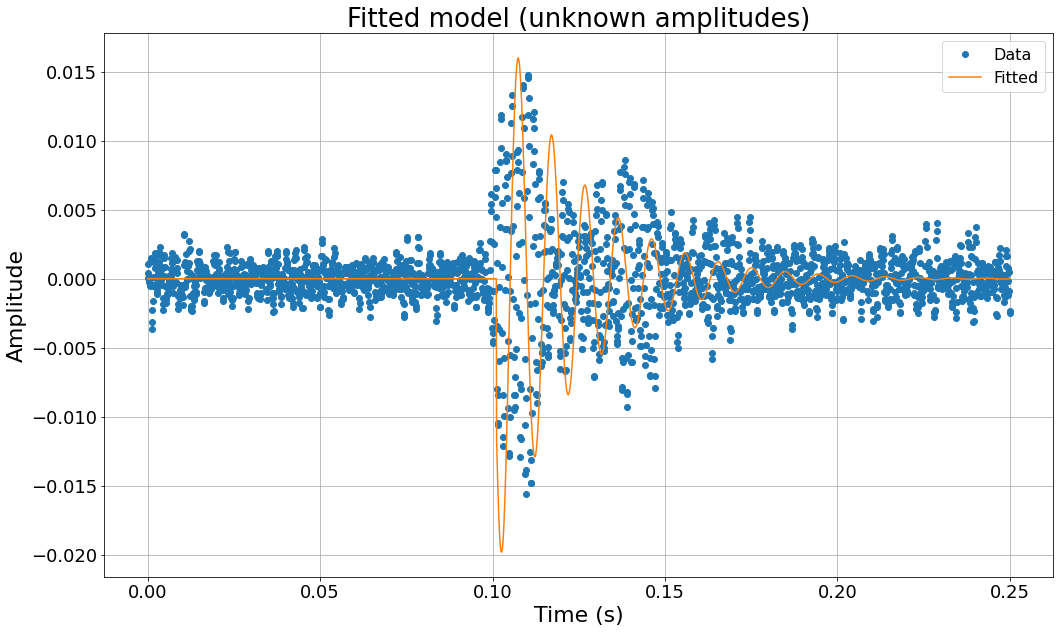

In [519]:
l_t = l_opt
omega_t = omega_opt
omega_t = 650
t_t = t_opt

y_fit = 0.01*np.exp(-l_t*(tb-t_t))*(1.5*np.cos(omega_t*tb) + 1.5*np.sin(omega_t*tb))
y_fit[np.where(tb < t_t)] = 0

fig = plt.figure(figsize = (17, 10))
plt.plot(tb, yb, 'o', label = 'Data')
plt.plot(tb, y_fit, '-', label = 'Fitted')
plt.xlabel('Time (s)', fontsize = 22)
plt.ylabel('Amplitude', fontsize = 22)
plt.title('Fitted model (unknown amplitudes)', fontsize = 26)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.legend(fontsize = 16)
plt.grid(True)
plt.show()

## Nonlinear parameters as functions of bubble diameter

In [37]:
o = abubble(yb,tb)

In [499]:
r1 = 1
r2 = 6
r3 = 2
t1, p1 = o.get_llhood_t(r1/1000)
t2, p2 = o.get_llhood_t(r2/1000)
t3, p3 = o.get_llhood_t(r3/1000)

/home/paulo/.local/lib/python3.6/site-packages/ipykernel_launcher.py:135: RuntimeWarning: overflow encountered in exp


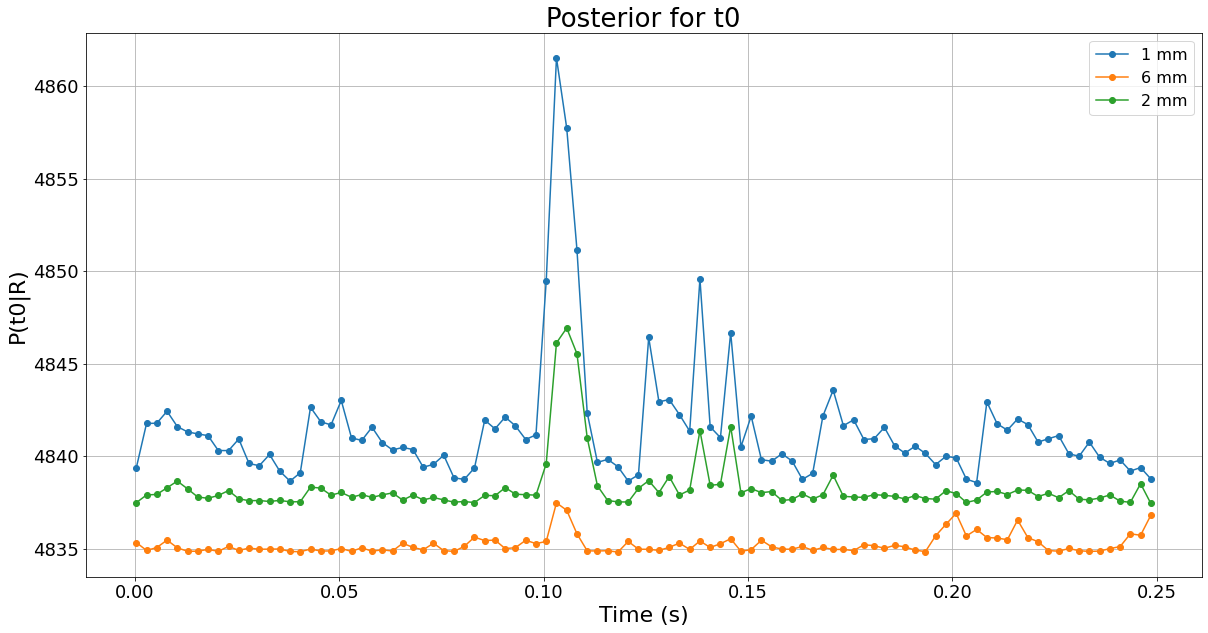

In [500]:
fig = plt.figure(figsize = (20, 10))

plt.plot(t1, p1, '-o', label = "{} mm".format(r1))
plt.plot(t2, p2, '-o', label = "{} mm".format(r2))
plt.plot(t3, p3, '-o', label = "{} mm".format(r3))

plt.xlabel('Time (s)', fontsize = 22)
plt.ylabel('P(t0|R)', fontsize = 22)
plt.title('Posterior for t0', fontsize = 26)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.legend(fontsize = 16)
plt.grid(True)

plt.show()

In [507]:
r_min = 3 / 1000
r_max = 15 / 1000
n_r = 500
n_t = 500

In [508]:
%%time
M, linr = bubblegram(o, r_min, r_max, n_r, n_t)
lint = np.linspace(o.t_min, o.t_max, n_t)

CPU times: user 6.47 s, sys: 118 ms, total: 6.59 s
Wall time: 18.3 s


In [509]:
i, j = np.unravel_index(np.argmax(M, axis=None), M.shape)
r_opt, topt = (linr[i], lint[j])

f_opt = o.omega(r_opt)
d_opt = o.delta(r_opt)

print("Maximum evidence for radius {:.5} mm with frequency {:.5} Hz and dumping constant {:.5} starting at {:.4} s".format(1000*r_opt, f_opt, d_opt, topt))

Maximum evidence for radius 11.104 mm with frequency 612.4 Hz and dumping constant 39.895 starting at 0.1013 s


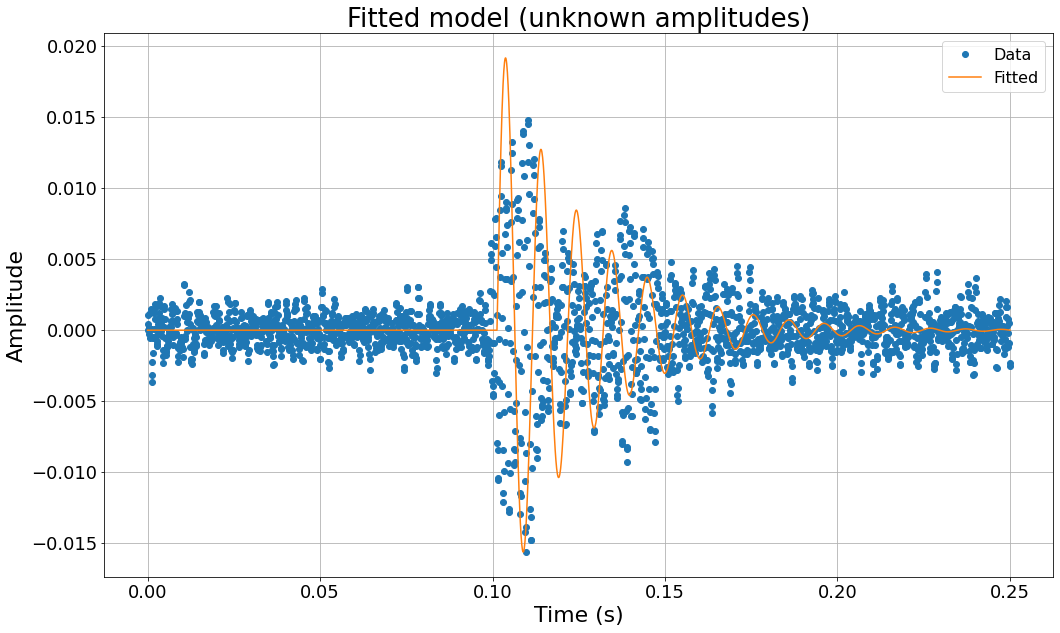

In [510]:
l_t = d_opt
omega_t = f_opt
t_t = topt

y_fit = 0.01*np.exp(-l_t*(tb-t_t))*(1.5*np.cos(omega_t*tb) + 1.5*np.sin(omega_t*tb))
y_fit[np.where(tb < t_t)] = 0

fig = plt.figure(figsize = (17, 10))
plt.plot(tb, yb, 'o', label = 'Data')
plt.plot(tb, y_fit, '-', label = 'Fitted')
plt.xlabel('Time (s)', fontsize = 22)
plt.ylabel('Amplitude', fontsize = 22)
plt.title('Fitted model (unknown amplitudes)', fontsize = 26)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.legend(fontsize = 16)
plt.grid(True)
plt.show()

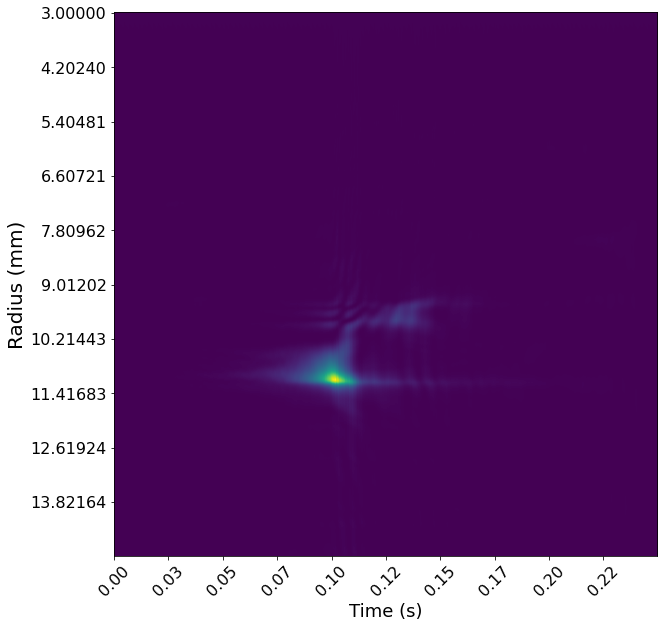

In [511]:
fig = plt.figure(figsize = (20, 10))
plt.imshow(M)

ticks_x = np.arange(0, len(lint), step = int(len(lint)/10))
plt.xticks(ticks_x, ["{:1.2f}".format(d) for d in lint[ticks_x]], rotation = 45, fontsize = 16)
plt.xlabel("Time (s)", fontsize = 18)

ticks_y = np.arange(0, len(linr), step = int(len(linr)/10))
plt.yticks(ticks_y, ["{:1.5f}".format(1000*o) for o in linr[ticks_y]], fontsize = 16)
plt.ylabel("Radius (mm)", fontsize = 20)

plt.show()

# Lab pulse train data

### Decimating

In [520]:
yb = decimate(yf, 10)
fs = int(fs / 10)
tb = np.linspace(0, len(yb)/fs, len(yb))

print("{} seconds of signal, {} points".format(len(yb)/fs, len(yb)))

299.946875 seconds of signal, 287949 points


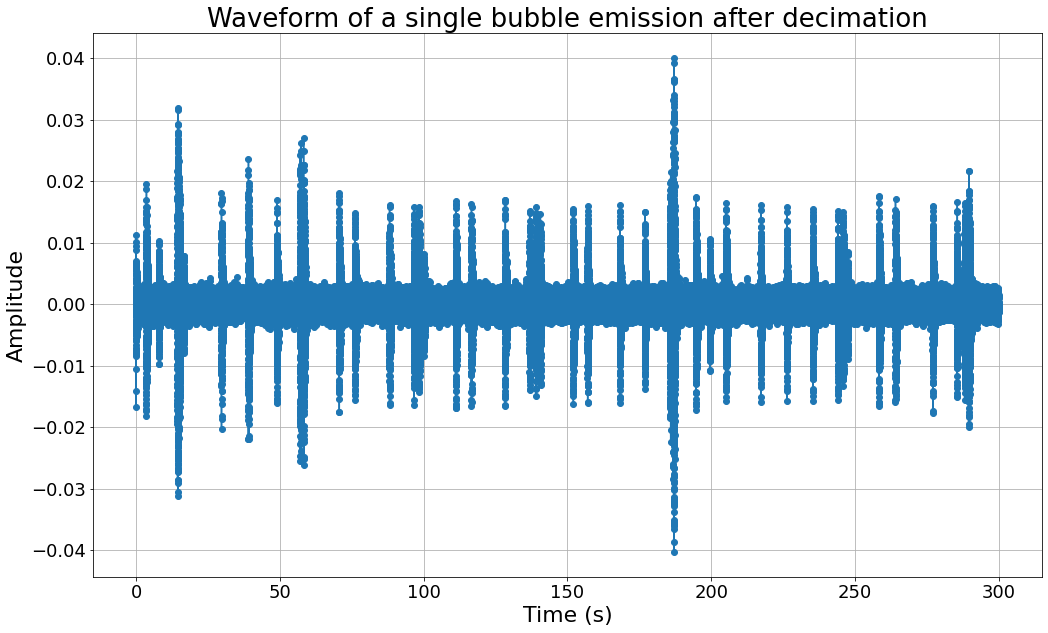

In [521]:
fig = plt.figure(figsize = (17, 10))
plt.plot(tb, yb, 'o-')
plt.xlabel('Time (s)', fontsize = 22)
plt.ylabel('Amplitude', fontsize = 22)
plt.title('Waveform of a single bubble emission after decimation', fontsize = 26)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.grid(True)
plt.show()

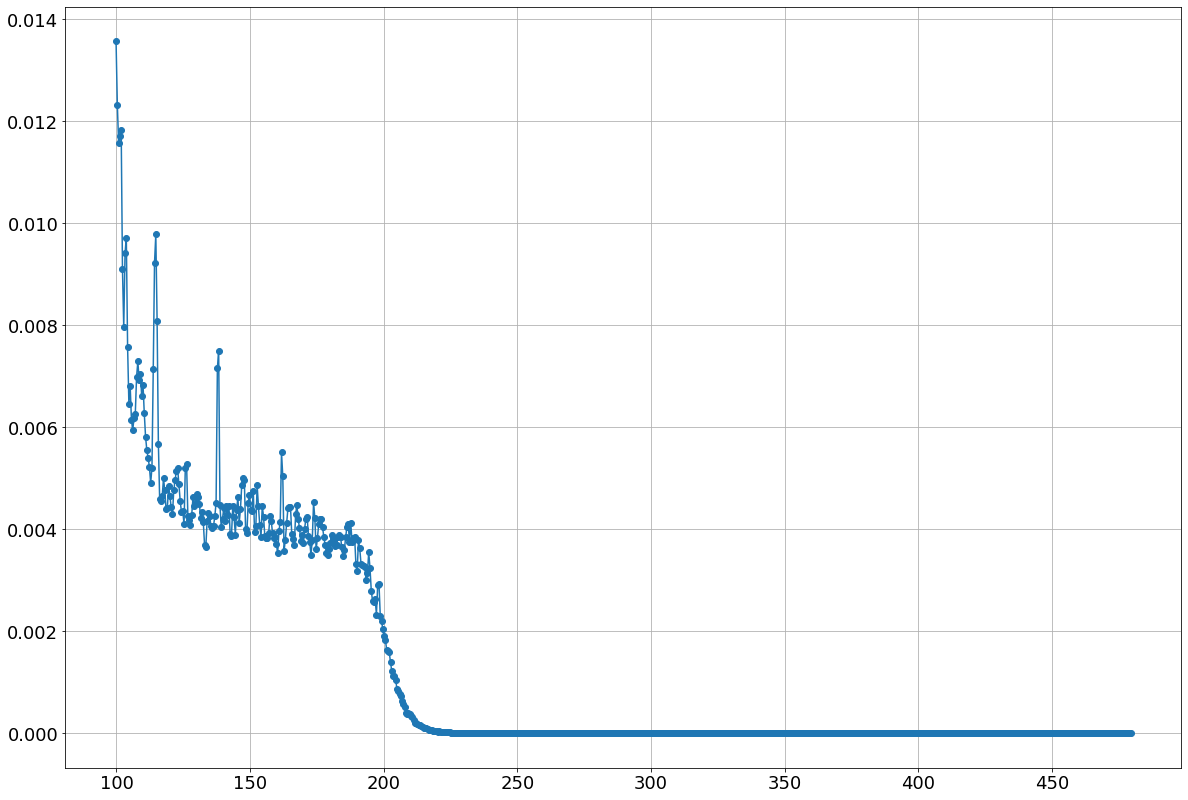

In [522]:
from scipy.signal import welch

f, psd = welch(yb, fs = fs, nperseg = 2000)


imin = np.argmin((f - 100)**2)
#imin = 0
imax = np.argmin((f - 1000)**2)
#imax = len(f)

psd = psd[imin:imax]    
f = f[imin:imax]
psd = psd / sum(psd)

plt.figure(figsize = (20, 14))
plt.plot(f, psd, 'o-')
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.grid(True)

# Modelling lab data

In [523]:
o = pulse(yb,tb)

In [524]:
param1 = (650, 43)
param2 = (1000, 43)
param3 = (650, 40)
t1, p = o.get_llhood_t(param1[0], param1[1])
t2, p2 = o.get_llhood_t(param2[0], param2[1])
t3, p3 = o.get_llhood_t(param3[0], param3[1])

/home/paulo/.local/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: overflow encountered in exp


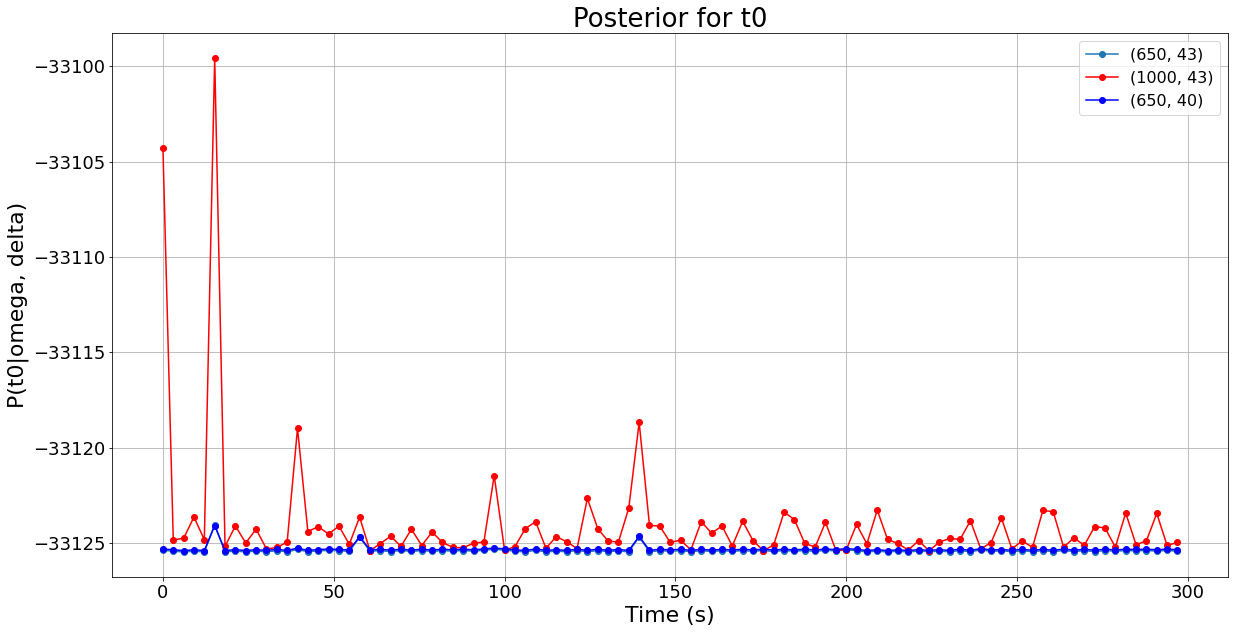

In [525]:
fig = plt.figure(figsize = (20, 10))

plt.plot(t1[:-1], p[:-1], '-o', label = param1)
plt.plot(t2[:-1], p2[:-1], '-o', color = 'red', label = param2)
plt.plot(t3[:-1], p3[:-1], '-o', color = 'blue', label = param3)

plt.xlabel('Time (s)', fontsize = 22)
plt.ylabel('P(t0|omega, delta)', fontsize = 22)
plt.title('Posterior for t0', fontsize = 26)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.legend(fontsize = 16)
plt.grid(True)
plt.show()

Pulsogram

In [526]:
omega_min = 100
omega_max = 1200
n_omega = 100
delta_min = 5
delta_max = 100
n_delta = 100

In [527]:
%%time
M, linomega, lindelta = pulsogram(o, omega_min, omega_max, n_omega, delta_min, delta_max, n_delta)

CPU times: user 1min 45s, sys: 1.64 s, total: 1min 47s
Wall time: 12h 15min 13s


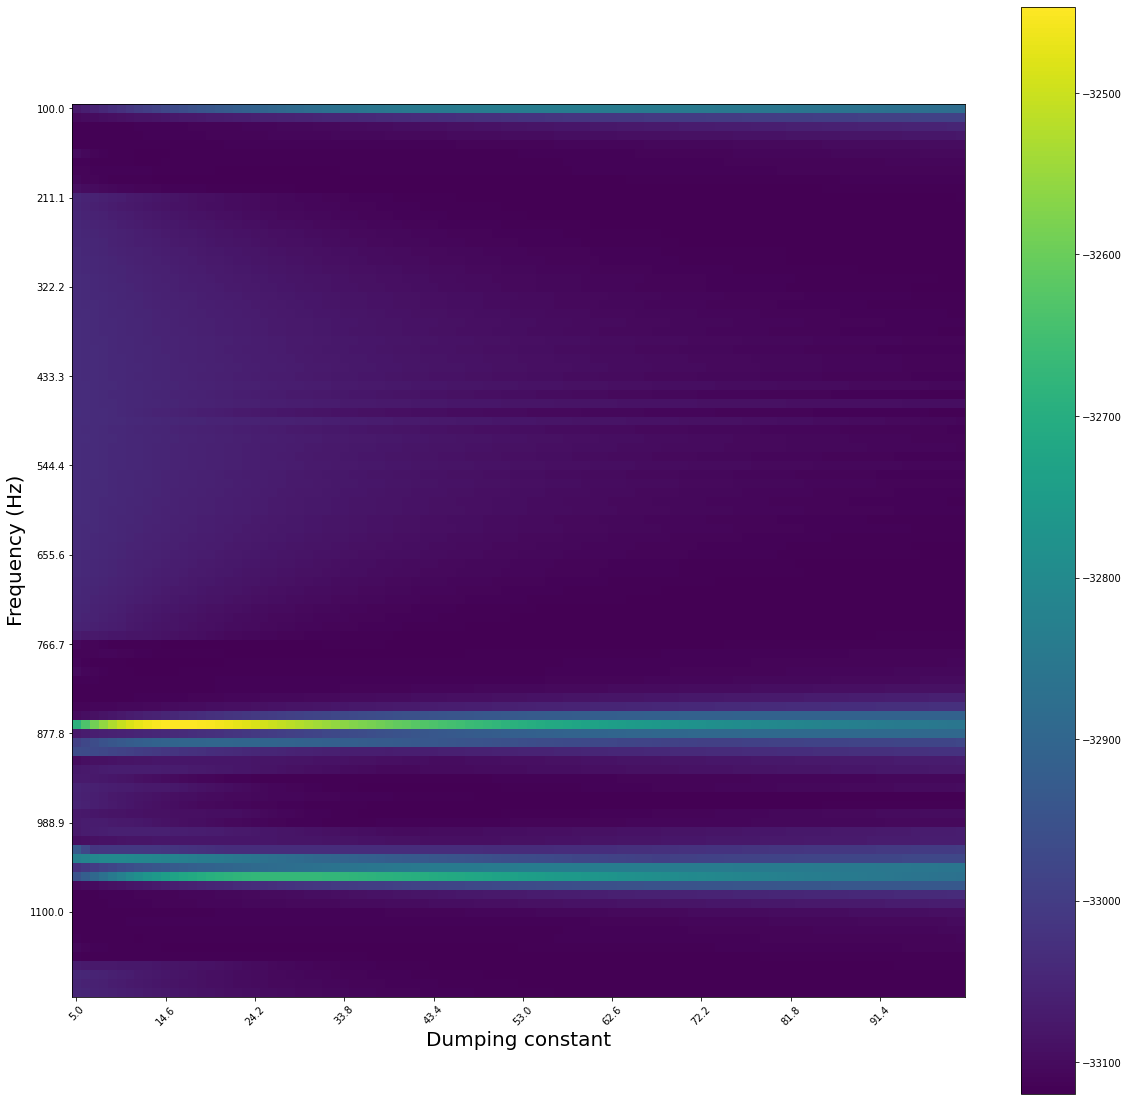

In [528]:
fig = plt.figure(figsize = (20, 20))
plt.imshow(M)

ticks_x = np.arange(0, len(lindelta), step = int(len(lindelta)/10))
plt.xticks(ticks_x, ["{:3.1f}".format(d) for d in lindelta[ticks_x]], rotation = 45)
plt.xlabel("Dumping constant", fontsize = 20)

ticks_y = np.arange(0, len(linomega), step = int(len(linomega)/10))
plt.yticks(ticks_y, ["{:4.1f}".format(o) for o in linomega[ticks_y]])
plt.ylabel("Frequency (Hz)", fontsize = 20)


plt.colorbar()
plt.show()

In [529]:
i, j = np.unravel_index(np.argmax(M, axis=None), M.shape)
omega_opt, l_opt = (linomega[i], lindelta[j])

topt, p = o.get_llhood_t(omega_opt, l_opt)
t_opt = topt[np.argmax(p)]

print("Maximum evidence for frequency {:.5} Hz and dumping constant {:.5} starting at {:.4} s".format(omega_opt, l_opt, t_opt))

/home/paulo/.local/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: overflow encountered in exp


Maximum evidence for frequency 866.67 Hz and dumping constant 16.515 starting at 15.15 s


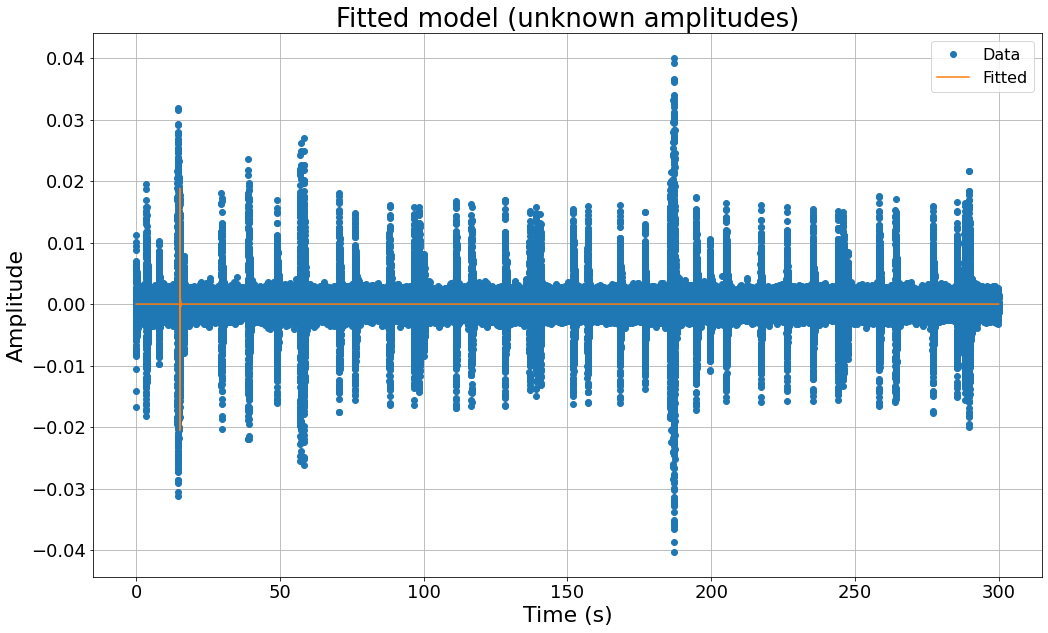

In [530]:
l_t = l_opt
omega_t = omega_opt
omega_t = 650
t_t = t_opt

y_fit = 0.01*np.exp(-l_t*(tb-t_t))*(1.5*np.cos(omega_t*tb) + 1.5*np.sin(omega_t*tb))
y_fit[np.where(tb < t_t)] = 0

fig = plt.figure(figsize = (17, 10))
plt.plot(tb, yb, 'o', label = 'Data')
plt.plot(tb, y_fit, '-', label = 'Fitted')
plt.xlabel('Time (s)', fontsize = 22)
plt.ylabel('Amplitude', fontsize = 22)
plt.title('Fitted model (unknown amplitudes)', fontsize = 26)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.legend(fontsize = 16)
plt.grid(True)
plt.show()

## Nonlinear parameters as functions of bubble diameter

In [531]:
o = abubble(yb,tb)

In [532]:
r1 = 1
r2 = 6
r3 = 2
t1, p1 = o.get_llhood_t(r1/1000)
t2, p2 = o.get_llhood_t(r2/1000)
t3, p3 = o.get_llhood_t(r3/1000)

/home/paulo/.local/lib/python3.6/site-packages/ipykernel_launcher.py:135: RuntimeWarning: overflow encountered in exp


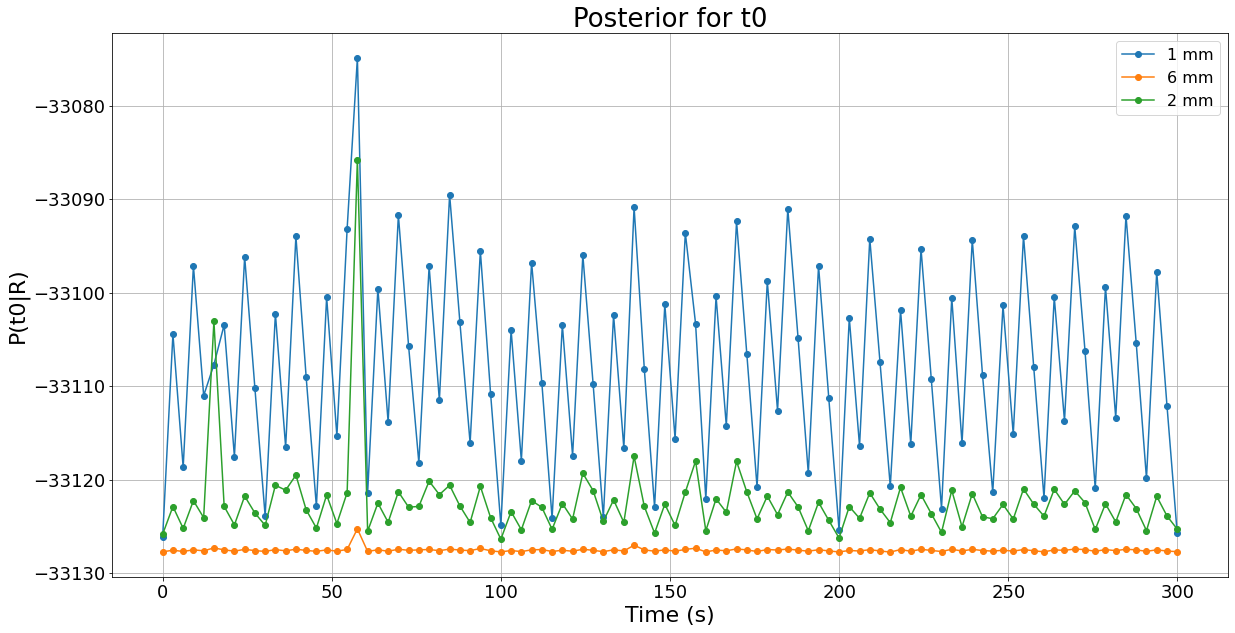

In [533]:
fig = plt.figure(figsize = (20, 10))

plt.plot(t1, p1, '-o', label = "{} mm".format(r1))
plt.plot(t2, p2, '-o', label = "{} mm".format(r2))
plt.plot(t3, p3, '-o', label = "{} mm".format(r3))

plt.xlabel('Time (s)', fontsize = 22)
plt.ylabel('P(t0|R)', fontsize = 22)
plt.title('Posterior for t0', fontsize = 26)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.legend(fontsize = 16)
plt.grid(True)

plt.show()

In [534]:
r_min = 3 / 1000
r_max = 15 / 1000
n_r = 500
n_t = 500

In [535]:
%%time
M, linr = bubblegram(o, r_min, r_max, n_r, n_t)
lint = np.linspace(o.t_min, o.t_max, n_t)

CPU times: user 7.13 s, sys: 164 ms, total: 7.29 s
Wall time: 3h 7min 20s


In [536]:
i, j = np.unravel_index(np.argmax(M, axis=None), M.shape)
r_opt, topt = (linr[i], lint[j])

f_opt = o.omega(r_opt)
d_opt = o.delta(r_opt)

print("Maximum evidence for radius {:.5} mm with frequency {:.5} Hz and dumping constant {:.5} starting at {:.4} s".format(1000*r_opt, f_opt, d_opt, topt))

Maximum evidence for radius 8.6032 mm with frequency 888.69 Hz and dumping constant 66.38 starting at 14.43 s


/home/paulo/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """


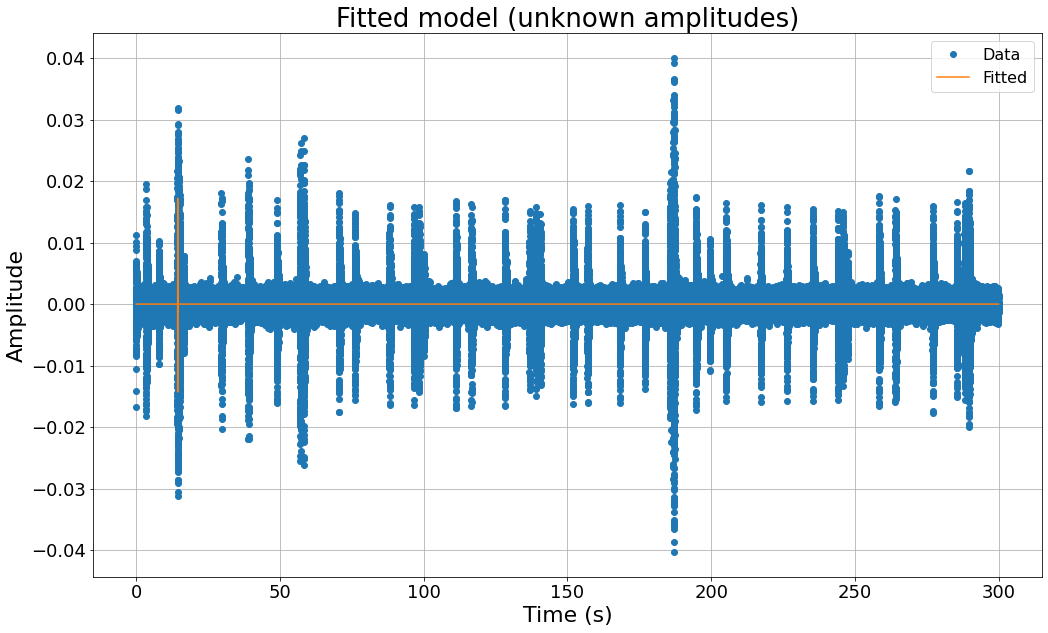

In [537]:
l_t = d_opt
omega_t = f_opt
t_t = topt

y_fit = 0.01*np.exp(-l_t*(tb-t_t))*(1.5*np.cos(omega_t*tb) + 1.5*np.sin(omega_t*tb))
y_fit[np.where(tb < t_t)] = 0

fig = plt.figure(figsize = (17, 10))
plt.plot(tb, yb, 'o', label = 'Data')
plt.plot(tb, y_fit, '-', label = 'Fitted')
plt.xlabel('Time (s)', fontsize = 22)
plt.ylabel('Amplitude', fontsize = 22)
plt.title('Fitted model (unknown amplitudes)', fontsize = 26)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.legend(fontsize = 16)
plt.grid(True)
plt.show()

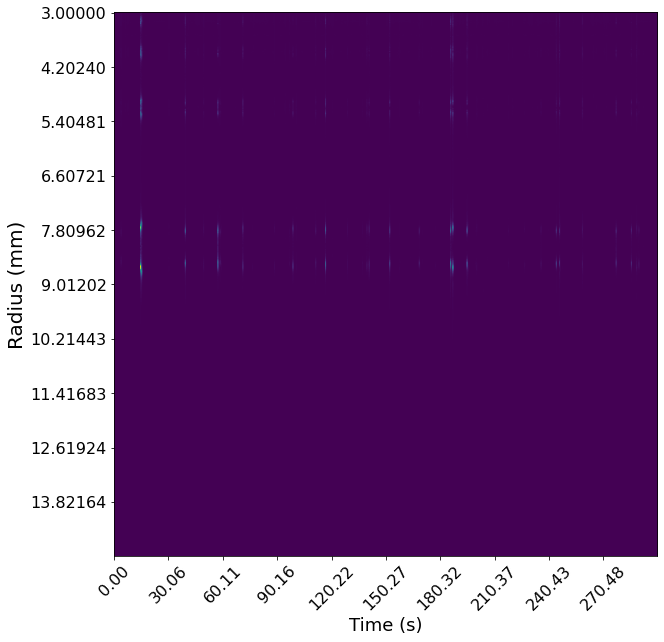

In [538]:
fig = plt.figure(figsize = (20, 10))
plt.imshow(M)

ticks_x = np.arange(0, len(lint), step = int(len(lint)/10))
plt.xticks(ticks_x, ["{:1.2f}".format(d) for d in lint[ticks_x]], rotation = 45, fontsize = 16)
plt.xlabel("Time (s)", fontsize = 18)

ticks_y = np.arange(0, len(linr), step = int(len(linr)/10))
plt.yticks(ticks_y, ["{:1.5f}".format(1000*o) for o in linr[ticks_y]], fontsize = 16)
plt.ylabel("Radius (mm)", fontsize = 20)

plt.show()